IMPORT MODULES

In [1]:
import numpy as np
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import matplotlib.gridspec as gridspec
import plotly.express as px
import plotly.io as pio

Creating SQL Alchemy engine object

In [2]:
engine = create_engine('oracle+cx_oracle://hr:hr@localhost:1521/xe')

Initializing connection to database

In [3]:
conn = engine.connect()

SQL query as string to pass into pd.read_sql function

In [4]:
sql='select * from HEALTHCARE'

Creating dataframe using sql statement and db connection

In [5]:
df = pd.read_sql_query(sql,conn)

Using plot background as dark

In [6]:
plt.style.use('dark_background')

I. PATIENT DEMOGRAPHICS

Patient count

In [7]:
pat_count='''
SELECT GENDER, count (*) as count
FROM HEALTHCARE
GROUP BY GENDER
'''
pat_df=pd.read_sql_query(pat_count,conn)

Age distribution

In [8]:
age_query='''
SELECT AGE, GENDER, BLOOD_TYPE
FROM HEALTHCARE
'''
age_df=pd.read_sql_query(age_query,conn)

Blood type distribution

In [9]:
bld_query='''
SELECT GENDER, BLOOD_TYPE, count (*) as count
FROM HEALTHCARE
GROUP BY BLOOD_TYPE, GENDER
ORDER BY BLOOD_TYPE DESC
'''
bld_df=pd.read_sql_query(bld_query,conn)

Subplot

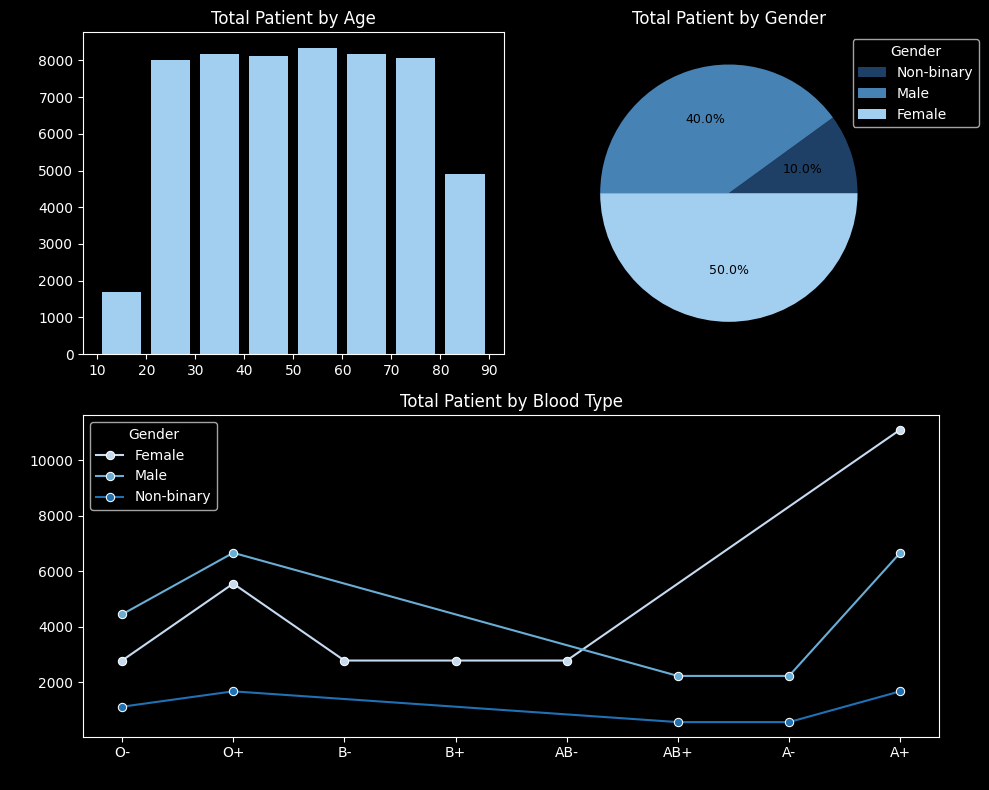

In [10]:
bins=np.arange(10,100,10)
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)

#Total Patient by Age'
fig.add_subplot(gs[0, 0])
plt.hist(age_df['age'],rwidth=0.8,bins=bins,color='#A2CFF0')
plt.xticks(bins)
plt.title('Total Patient by Age')

#Total Patient by Gender
fig.add_subplot(gs[0, 1])
textprops={'fontsize':9,'color':'k'}
color=['#1E3F66','#4682B4','#A2CFF0']
plt.pie(pat_df['count'],labels=pat_df['gender'],autopct='%0.1f%%',textprops=textprops,colors=color)
plt.legend(title='Gender',loc='upper right',bbox_to_anchor=(1.3,1))
plt.title('Total Patient by Gender')

#Total Patient by Blood Type
fig.add_subplot(gs[1, :])
sns.lineplot(x='blood_type',y='count',data=bld_df,marker='o',hue='gender',palette='Blues')
plt.legend(title='Gender')
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Total Patient by Blood Type')

plt.tight_layout()
plt.show()

II. HOSPITAL AND ADMISSIONS INSIGHTS

Admission by hospitals

In [11]:
adm_query='''
SELECT ADMISSION_TYPE, HOSPITAL, COUNT (*) AS count
FROM HEALTHCARE
GROUP BY HOSPITAL, ADMISSION_TYPE
ORDER BY HOSPITAL DESC
'''
adm_df=pd.read_sql_query(adm_query,conn)

Admission over time

In [12]:
adm1_query='''
SELECT HOSPITAL, DATE_OF_ADMISSION, COUNT (PATIENT_ID) AS admcount
FROM HEALTHCARE
GROUP BY DATE_OF_ADMISSION,HOSPITAL
ORDER BY DATE_OF_ADMISSION ASC
'''
adm1_df=pd.read_sql_query(adm1_query,conn)

Pivot table for admission over year

In [13]:
adm1_df['date_of_admission'] = pd.to_datetime(adm1_df['date_of_admission'])
adm1_df['YEAR'] = adm1_df['date_of_admission'].dt.year
adm1_df['MONTH'] = adm1_df['date_of_admission'].dt.month
pivot = adm1_df.pivot_table(index='hospital', columns='YEAR', values='admcount', aggfunc='sum')

Subplot

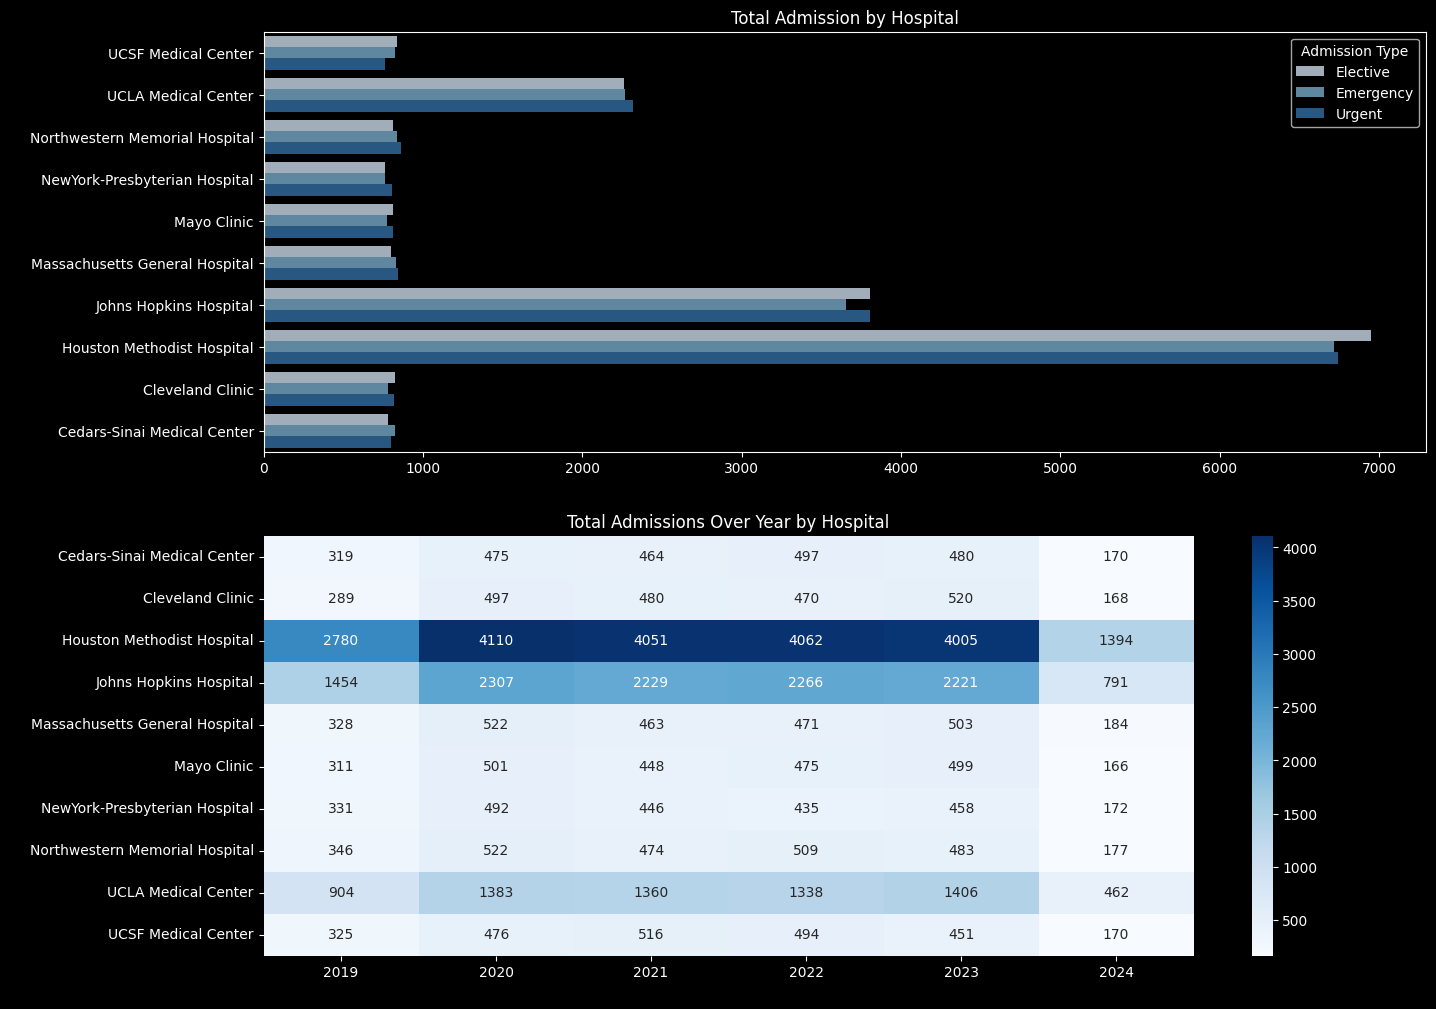

In [14]:
plt.figure(figsize=(15,12))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

#Total Admission by Hospital
plt.subplot(gs[0])
sns.barplot(y='hospital',x='count',data=adm_df,hue='admission_type',palette='Blues',orient='h',alpha=0.8)
plt.legend(title='Admission Type')
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Total Admission by Hospital')

#Total Admissions Over Year by Hospital
ax1 = plt.subplot(gs[1])
adm=sns.heatmap(pivot,annot=True,fmt='.0f',cmap='Blues')
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Total Admissions Over Year by Hospital')

plt.show()

III. MEDICAL CONDITIONS, MEDICATIONS & DEMOGRAPHIC INSIGHTS

Medical condition & Medications

In [44]:
medexp_query='''
SELECT MEDICATION, MEDICAL_CONDITION, ROUND(AVG(BILLING_AMOUNT)) AS MEDCON
FROM HEALTHCARE
GROUP BY MEDICATION,MEDICAL_CONDITION
ORDER BY MEDICATION DESC
'''
medexp_df=pd.read_sql_query(medexp_query,conn)

Pivot table for average medications expense by medical conditions

In [50]:
medexp_pivot = medexp_df.pivot_table(index='medical_condition', columns='medication', values='medcon', aggfunc='sum')

Medical conditions by age range

In [41]:
medage_query='''
SELECT AGE, MEDICAL_CONDITION, COUNT (*) AS MEDAGE,
CASE
    WHEN AGE BETWEEN 11 AND 19 THEN '10-19'
    WHEN AGE BETWEEN 20 AND 29 THEN '20-29'
    WHEN AGE BETWEEN 30 AND 39 THEN '30-39'
    WHEN AGE BETWEEN 40 AND 49 THEN '40-49'
    WHEN AGE BETWEEN 50 AND 59 THEN '50-59'
    WHEN AGE BETWEEN 60 AND 69 THEN '60-69'
    WHEN AGE BETWEEN 70 AND 79 THEN '70-79'
    WHEN AGE BETWEEN 80 AND 89 THEN '80-89'
    END RANGES
FROM HEALTHCARE
GROUP BY AGE, MEDICAL_CONDITION
ORDER BY AGE
'''
medage_df=pd.read_sql_query(medage_query,conn)

Pivot table for medical conditions by age range

In [42]:
medage_pivot = medage_df.pivot_table(index='ranges', columns='medical_condition',values='medage', aggfunc='sum')

Subplot

Text(0.5, 1.0, 'Medical Conditions by Age')

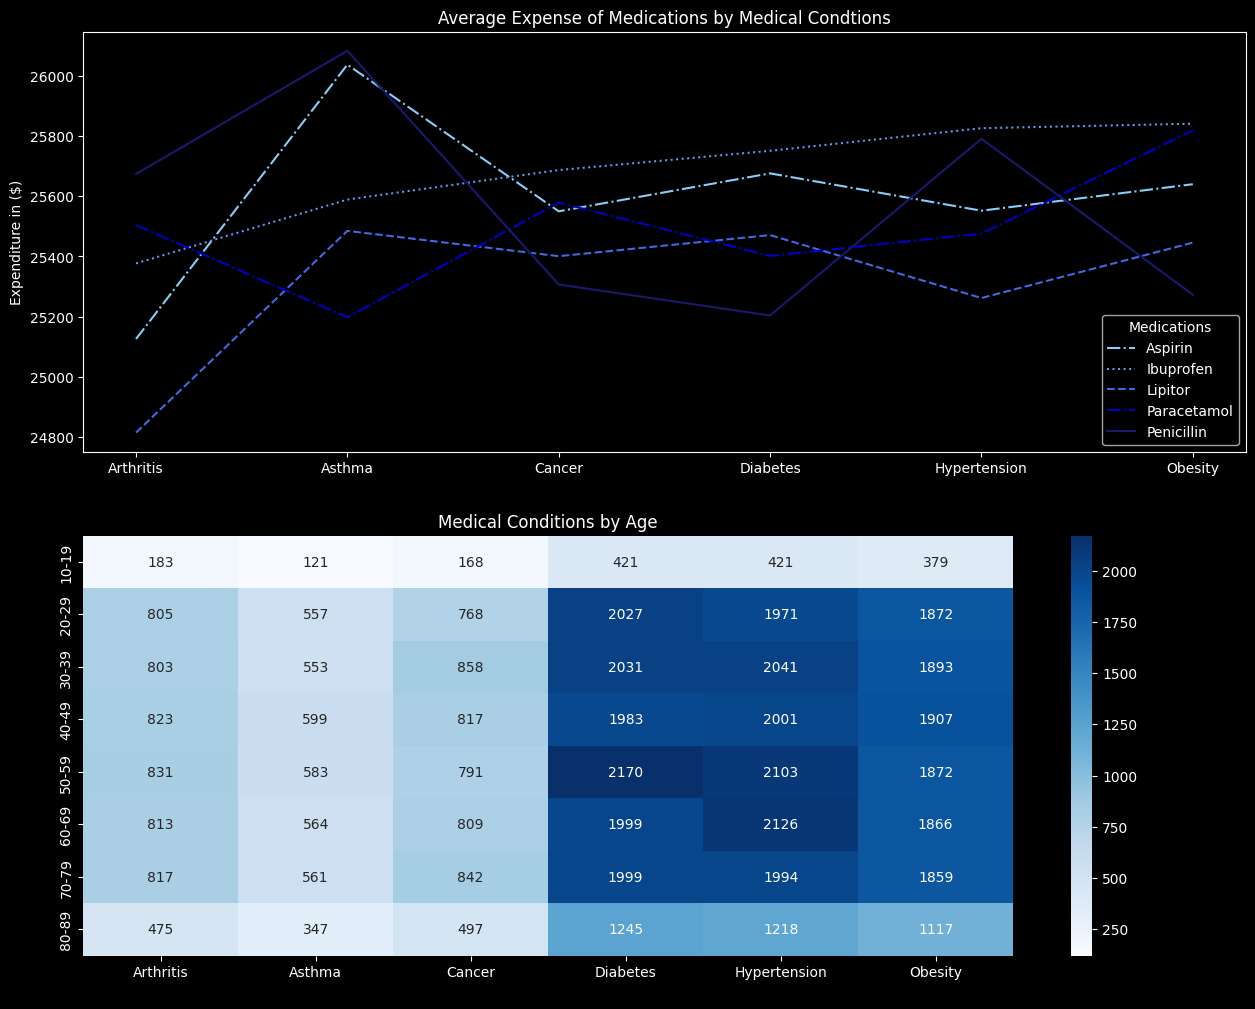

In [49]:
plt.figure(figsize=(15,12))
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

#Average Expense of Medications by Medical Condtions
plt.subplot(gs1[0])
plt.plot(medexp_pivot.index,medexp_pivot['Aspirin'],linestyle='-.',color='#87CEFA')
plt.plot(medexp_pivot.index,medexp_pivot['Ibuprofen'],linestyle=':',color='#6495ED')
plt.plot(medexp_pivot.index,medexp_pivot['Lipitor'],linestyle='--',color='#4169E1')
plt.plot(medexp_pivot.index,medexp_pivot['Paracetamol'],linestyle='-.',color='#0000CD')
plt.plot(medexp_pivot.index,medexp_pivot['Penicillin'],linestyle='-',color='#191970')
plt.ylabel('Expenditure in ($)')
plt.legend(medexp_pivot.columns,title='Medications')
plt.title('Average Expense of Medications by Medical Condtions')

#Medical Conditions by Age
ax2 = plt.subplot(gs1[1])
medage=sns.heatmap(medage_pivot,annot=True,fmt='.0f',cmap='Blues')
plt.xlabel(' ')
plt.ylabel(' ')
plt.title('Medical Conditions by Age')

IV. FINANCIAL OVERVIEW

Average bill amount by hospital

In [20]:
insexp_query='''
SELECT INSURANCE_PROVIDER, HOSPITAL, COUNT(*) AS MEDCON,
ROUND(SUM(BILLING_AMOUNT)) AS BILL,
ROUND(AVG(BILLING_AMOUNT)) AS AVGBILL
FROM HEALTHCARE
GROUP BY INSURANCE_PROVIDER,HOSPITAL
ORDER BY HOSPITAL
'''
insexp_df=pd.read_sql_query(insexp_query,conn)

Insurance usages by patient

In [21]:
ins = 'SELECT INSURANCE_PROVIDER, count(*) AS count FROM HEALTHCARE GROUP BY INSURANCE_PROVIDER'
df1 = pd.read_sql_query(ins,conn)
df1.columns

Index(['insurance_provider', 'count'], dtype='object')

In [ ]:
# Find hospital with the lowest average bill
min_avg = insexp_df.loc[insexp_df['avgbill'].idxmin()]

# Find hospital with the highest average bill
max_avg = insexp_df.loc[insexp_df['avgbill'].idxmax()]

print("Hospital with the Lowest Average Bill:")
print(f"{min_avg['hospital']} - ${min_avg['avgbill']:,.2f}")

print("\nHospital with the Highest Average Bill:")
print(f"{max_avg['hospital']} - ${max_avg['avgbill']:,.2f}")

Hospital with the Lowest Average Bill:


KeyError: 'avg_bill'

Subplot

C:\Users\129ra\AppData\Local\Temp\ipykernel_7444\635774755.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=insexp_df, y='hospital', x='avgbill',palette='Blues')


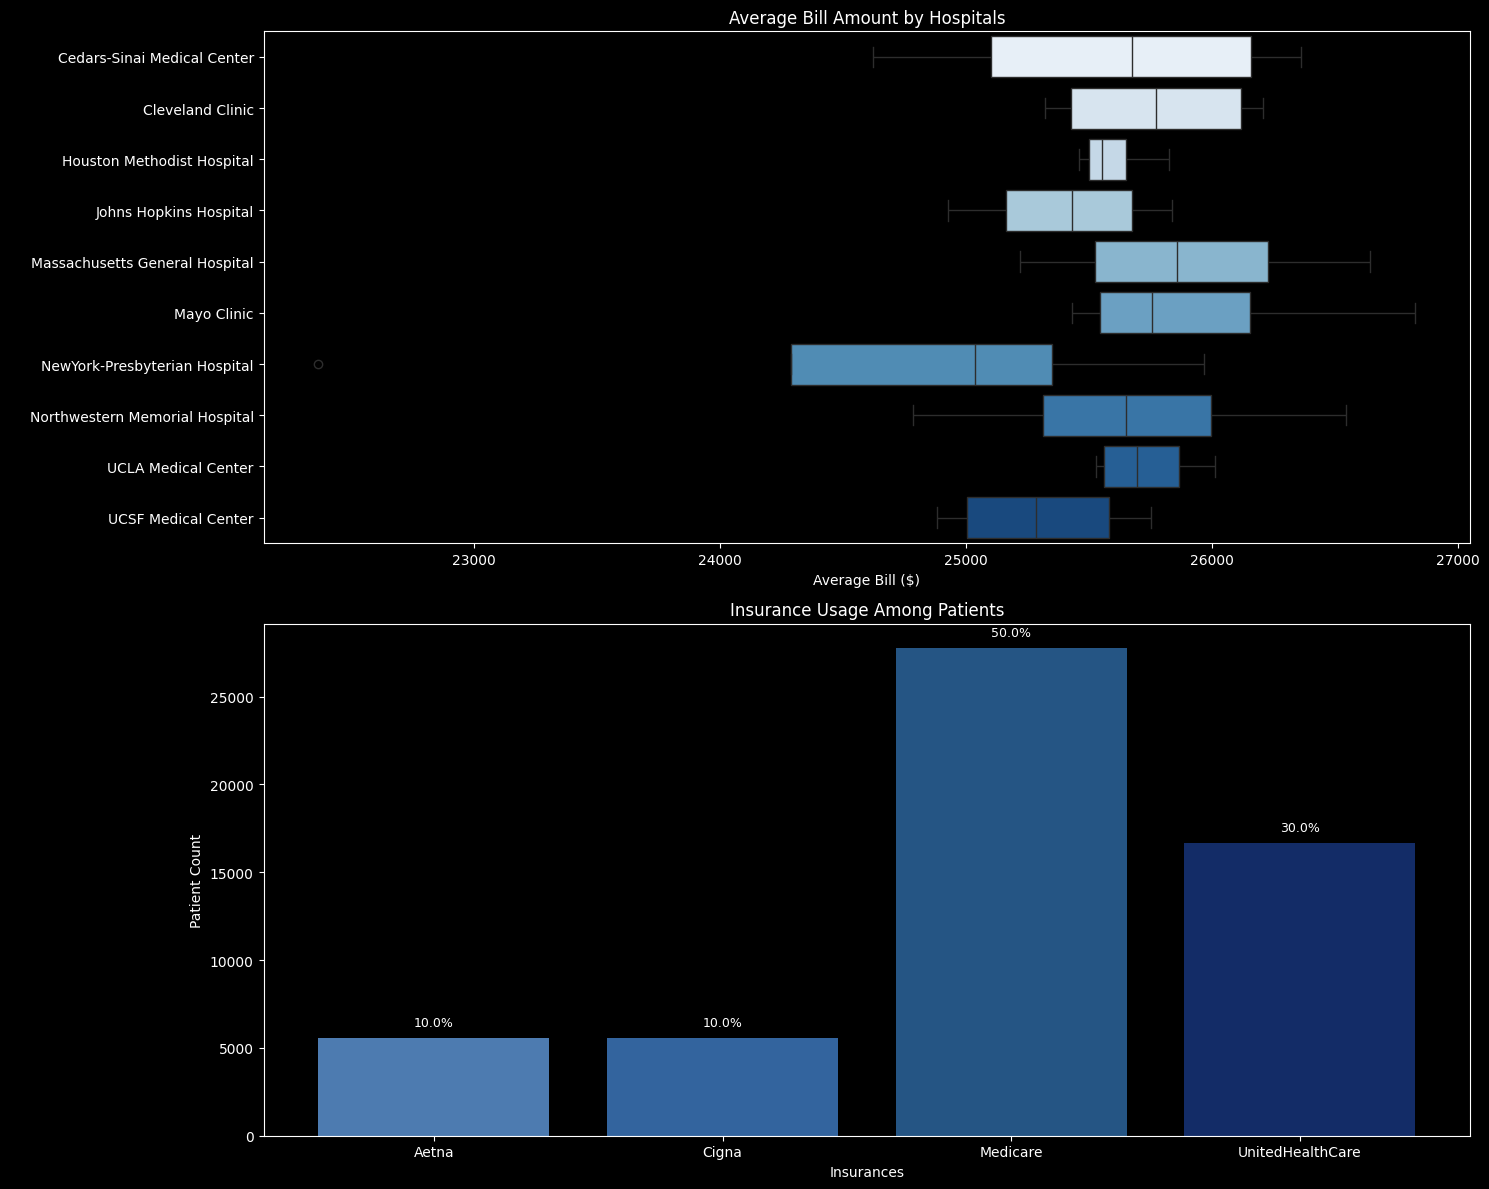

In [22]:
plt.figure(figsize=(15,12))
gs2 = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

#Average Bill Amount by Hospitals
plt.subplot(gs2[0])
sns.boxplot(data=insexp_df, y='hospital', x='avgbill',palette='Blues')
plt.xlabel('Average Bill ($)')
plt.ylabel(' ')
plt.title('Average Bill Amount by Hospitals')
plt.tight_layout()

#Insurance Usage Among Patients
ax3 = plt.subplot(gs2[1])
colors=['#6FB1FC','#4A90E2','#357ABD','#1C3F94']
total = df1['count'].sum()
bars=plt.bar(df1['insurance_provider'],df1['count'],color=colors,alpha=0.7)
for bar in bars:
    height = bar.get_height()
    percent = (height / total) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height + 500,
             f'{percent:.1f}%',  # Format as 1 decimal percentage
             ha='center', va='bottom', fontsize=9, color='white')
plt.title('Insurance Usage Among Patients')
plt.xlabel('Insurances')
plt.ylabel('Patient Count')
plt.tight_layout()

plt.show()

V. STAY DURATION

Average stay duration by medical conditions

In [23]:
dur_query='''
SELECT HOSPITAL, MEDICAL_CONDITION,
ROUND(AVG(DISCHARGE_DATE - DATE_OF_ADMISSION)) AS STAY_DUR
FROM HEALTHCARE
GROUP BY HOSPITAL, MEDICAL_CONDITION
'''
dur_df=pd.read_sql_query(dur_query,conn)

Average stay duration vs. Avergae bill amount by hospital

In [24]:
stay_query='''
SELECT HOSPITAL,
ROUND(AVG(DISCHARGE_DATE - DATE_OF_ADMISSION)) AS STAY_DUR,
ROUND(AVG(BILLING_AMOUNT)) AS AVGBILL
FROM HEALTHCARE
GROUP BY HOSPITAL
'''
stay_df=pd.read_sql_query(stay_query,conn)

Subplot

C:\Users\129ra\AppData\Local\Temp\ipykernel_7444\1430369754.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='stay_dur', y='medical_condition', data=dur_df,palette='Blues')


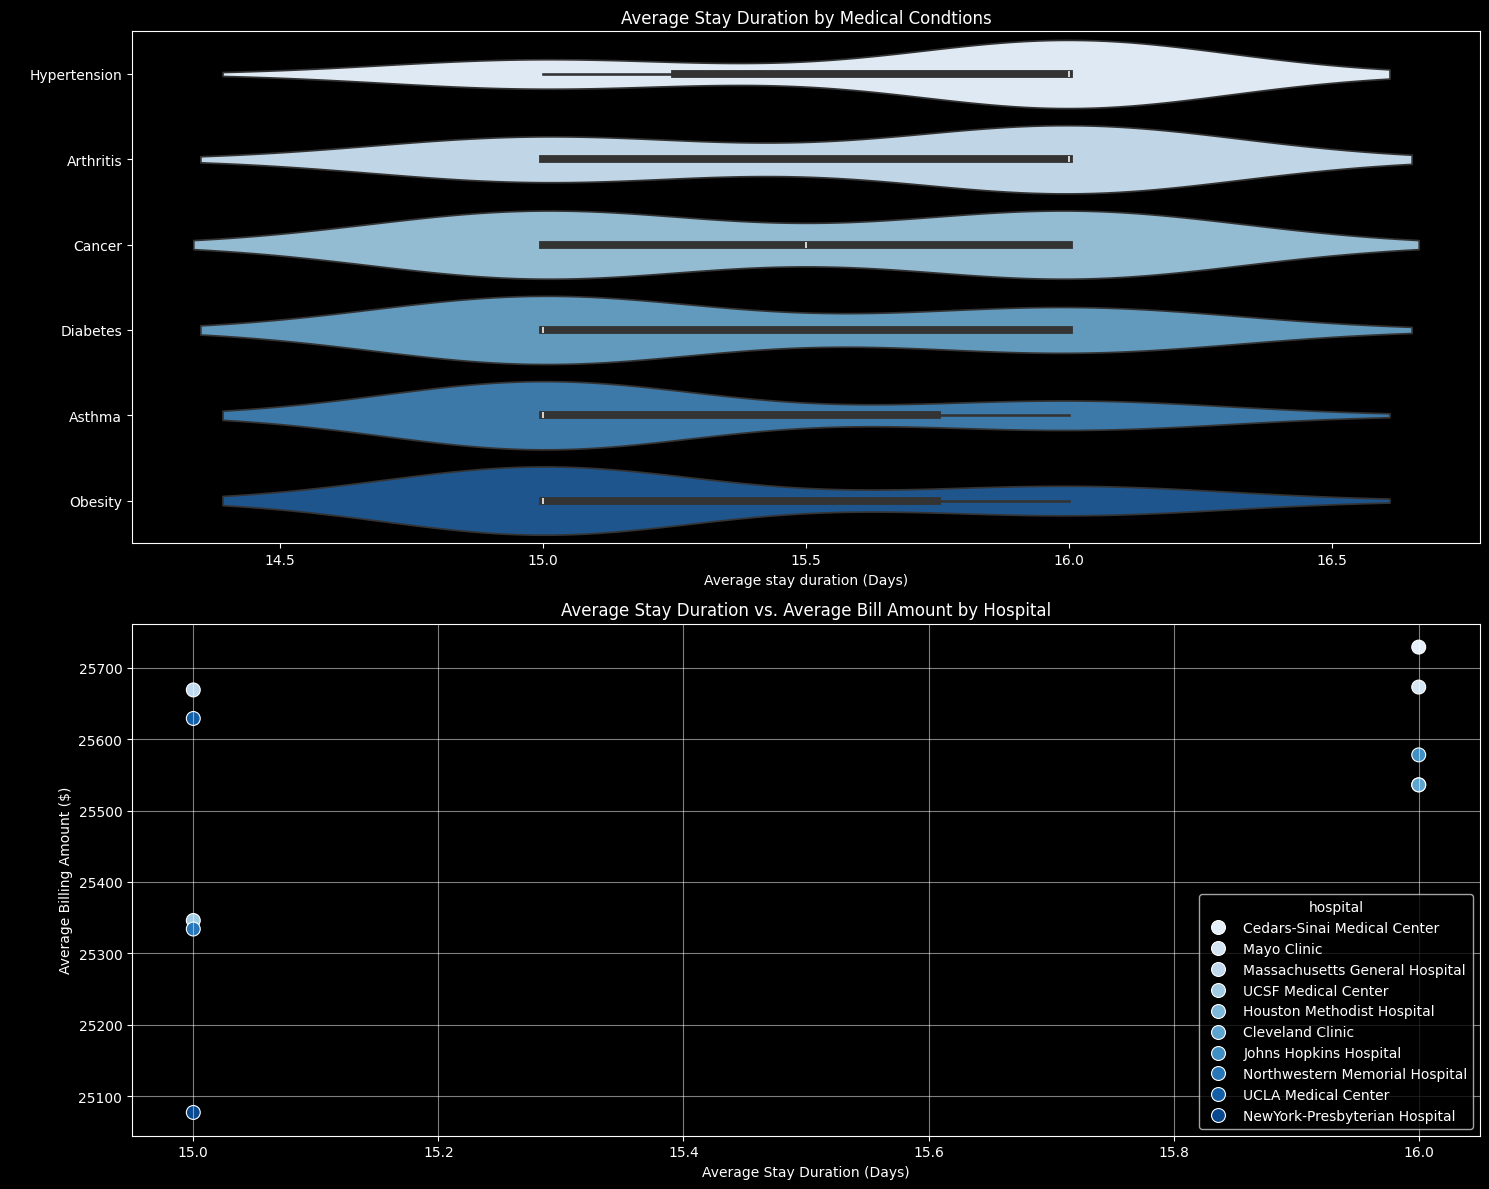

In [ ]:
plt.figure(figsize=(15,12))
gs3 = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

#Average Stay Duration by Medical Condtions
plt.subplot(gs3[0])
sns.violinplot(x='stay_dur', y='medical_condition', data=dur_df,palette='Blues')
plt.title('Average Stay Duration by Medical Condtions')
plt.xlabel('Average stay duration (Days)')
plt.ylabel(' ')

#Average Stay Duration vs. Average Bill Amount by Hospital
ax3 = plt.subplot(gs3[1])
sns.scatterplot(x='stay_dur', y='avgbill', hue='hospital', data=stay_df, s=100,palette='Blues')
plt.title("Average Stay Duration vs. Average Bill Amount by Hospital")
plt.xlabel("Average Stay Duration (Days)")
plt.ylabel("Average Billing Amount ($)")
plt.grid(True,alpha=0.5)
plt.tight_layout()

plt.show()

VI. GEOGRAPHIC INSIGHTS

In [ ]:
geo_query='''
SELECT HOSPITAL, HOSPITAL_LATITUDE, HOSPITAL_LONGITUDE, COUNT (*) AS PAT_COUNT
FROM HEALTHCARE
GROUP BY HOSPITAL, HOSPITAL_LATITUDE, HOSPITAL_LONGITUDE
ORDER BY HOSPITAL
'''
geo_df=pd.read_sql_query(geo_query,conn)

Hospital Locations

In [28]:
pio.renderers.default = 'browser'

fig = px.scatter_geo(
    geo_df,
    lat='hospital_latitude',
    lon='hospital_longitude',
    text='hospital',
    size='pat_count',
    color='pat_count',
    projection='natural earth',
    title="Hospital Locations and Patient Volume"
)

fig.show()
